In [66]:
import sys
sys.path.append('C:/Users/james/OneDrive/바탕 화면/대학교/수업/2024-1/물류관리/Term_project/Modules')

import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import combinations
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from utils import *

from savings.link import Link
from savings.node import Node
from savings.graph import Graph
from savings.route import Route
from savings.SavingsModel import SavingsModel

from savings.SavingsAlgorithm import Clarke_Wright_Savings

In [56]:
DEPOT_INDEX = 0
COST_TYPE = 'trafast'
JSON_PATH = './../Data/routes_with_depot'
mu = 500
std = 200
ub = 800

node_data = pd.read_csv('./../Data/data_with_depot.csv')

In [57]:
# 문제 상황에 대한 Graph 객체 만들기
g = Graph()

# Node 등록
for row in node_data.iterrows():
    data = row[1]

    # Node의 demand 생성 로직
    machine_num = data['machine']
    node_demand = 0
    # 기기수만큼 정규분포에서 랜덤 샘플링을 진행하여 더해줌
    while(machine_num != 0):
        node_demand += np.random.normal(mu, std)
        machine_num -= 1
    node_demand = round(node_demand)
    if node_demand < 0:
        node_demand = 0
    if node_demand > ub:
        node_demand = ub
    

    # Node 생성 후 등록
    n = Node(data['index'], data['longitude'], data['latitude'], node_demand)
    g.add_node(n)

# Link 등록
for n1, n2 in tqdm([comb for comb in combinations(g.nodes, 2)]):
    if n1.index > n2.index:
        temp = n2
        n2 = n1
        n1 = temp

    link_cost = get_cost(n1.index, n2.index, COST_TYPE, JSON_PATH, toll_include=True)
    l = Link(n1, n2, link_cost)
    g.add_link(l)

# 임시: depot의 demand는 0으로 설정
g.get_node(DEPOT_INDEX).demand = 0

100%|██████████| 2145/2145 [00:13<00:00, 157.12it/s]


In [63]:
DEPOT_INDEX = 0
CAPA = 10000
JSON_PATH = './../Data/routes_with_depot'

svm = SavingsModel(g, DEPOT_INDEX)
svm.calculate_savings()
svm.apply_algorithm(CAPA)

SavingsModel initialized
Calculating savings for 65 nodes, 
[Depot node] Node 0 (127.0742785, 35.01668803) : Demand 0


100%|██████████| 2080/2080 [00:00<00:00, 6735.46it/s] 


Iterating through the savings info ...


100%|██████████| 2080/2080 [00:00<00:00, 64965.50it/s]


In [64]:
for r in svm.routes:
    print(r)

print(f'\n최대 적재량 {CAPA:,}개\n운송비 {svm.cost:,}원\n총 수거량 {svm.demand:,}개\n기기 분포 ~ N({mu}, {std})')


Route : 0 - 20 - 45 - 29 - 30 - 1 - 39 - 19 - 42 - 23 - 54 - 32 - 22 - 15 - 14 - 49 - 0
Demand met : 9831, Cost : 24674
Route : 0 - 53 - 50 - 12 - 40 - 8 - 41 - 47 - 48 - 17 - 37 - 38 - 18 - 28 - 0
Demand met : 9344, Cost : 44557
Route : 0 - 11 - 6 - 9 - 16 - 44 - 2 - 3 - 5 - 4 - 27 - 24 - 26 - 33 - 43 - 31 - 13 - 0
Demand met : 9631, Cost : 21702
Route : 0 - 35 - 21 - 36 - 34 - 51 - 7 - 46 - 25 - 0
Demand met : 4363, Cost : 21242
Route : 0 - 56 - 62 - 63 - 60 - 57 - 55 - 58 - 65 - 61 - 64 - 59 - 10 - 52 - 0
Demand met : 7283, Cost : 16313

최대 적재량 10,000개
운송비 128,488원
총 수거량 40,452개
기기 분포 ~ N(500, 200)


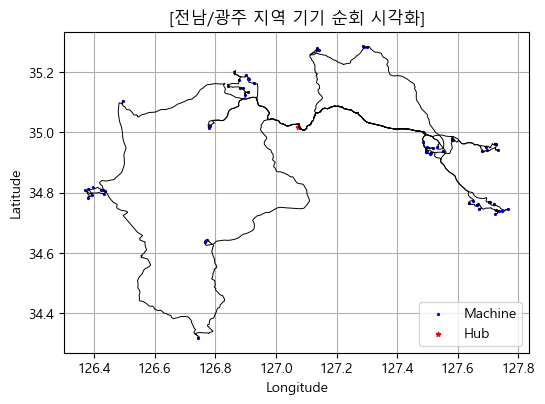

In [65]:
# figsize 비율 계산
ratio = (node_data.latitude.max() - node_data.latitude.min()) / (node_data.longitude.max() - node_data.longitude.min())
scale = 6

# fig, ax 객체 생성
fig, ax = plt.subplots(figsize=(scale, scale * ratio))

# 데이터 플롯
ax.scatter(node_data['longitude'], node_data['latitude'], s=1.8, c='blue', label='Machine')
ax.scatter(svm.depot.x, svm.depot.y, s=10, c='red', label='Hub', marker='*')

# 축 레이블, 제목 및 범례 설정
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('[전남/광주 지역 기기 순회 시각화]', fontsize=12)
ax.grid()

# 그래프를 보여줍니다.
ax.legend(loc='lower right')

# 각 route를 visualize
for route in svm.routes:
    route.visualize(ax, JSON_PATH, route_option='trafast', update_sec = 0.05)